<a href="https://colab.research.google.com/github/ProjectPortfolio/Image_Processing/blob/main/prepare_imagedataset_for_imageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
from skimage.morphology import disk
from skimage.filters import median

In [34]:
# defining global variable path
# Location of my dataset on My Google Drive
image_path = "/content/drive/My Drive/Image_dataset"
import tensorflow as tf

def loadImages(path):
    '''Put files into lists and return them as one list with all images 
     in the folder'''
    image_files = sorted([os.path.join(image_path, file)
                          for file in os.listdir(image_path)
                          if file.endswith('.jpg')])
    return image_files



In [6]:
# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.show()



In [44]:
# Preprocessing
def processing(data):
    
    # Reading 3 images to work
    img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in data[:3]]
    try:
        print('Original size',img[0].shape)
    except AttributeError:
        print("shape not found")
   
    # --------------------------------
    # setting dim of the resize
    height = 512
    width = 512
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)

    # Checcking the size
    try:
        print('RESIZED', res_img[1].shape)
    except AttributeError:
        print("shape not found")
    
    
    # Visualizing one of the images in the array
    original = res_img[1]
    display_one(original)
    # ----------------------------------
    # Remove noise
    # Using Gaussian Blur
    no_noise = []
    for i in range(len(res_img)):
        blur = cv2.GaussianBlur(res_img[i], (5, 5), 0)
        no_noise.append(blur)


    image = no_noise[1]
    display(original, image, 'Original', 'Blured')
    #---------------------------------
    # Segmentation
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Displaying segmented images
    display(original, thresh, 'Original', 'Segmented')
    # Further noise removal (Morphology)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    #Displaying segmented back ground
    display(original, sure_bg, 'Original', 'Segmented Background')

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]

    # Displaying markers on the image
    display(original, markers, 'Original', 'Marked')

number of FILES in dir 10
--------------------------------
List of files the first 3 in the folder:
 ['/content/drive/My Drive/Image_dataset/00000.jpg', '/content/drive/My Drive/Image_dataset/00001.jpg', '/content/drive/My Drive/Image_dataset/00002.jpg']
--------------------------------
Original size (3744, 5616, 3)
RESIZED (512, 512, 3)


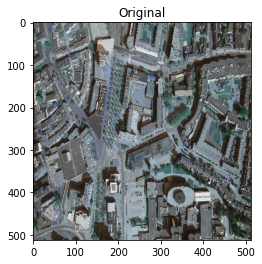

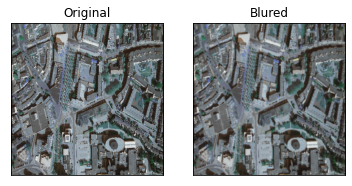

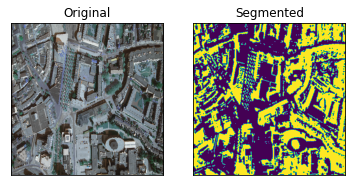

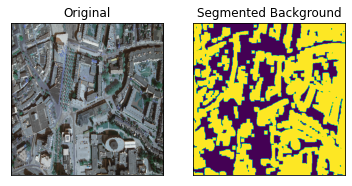

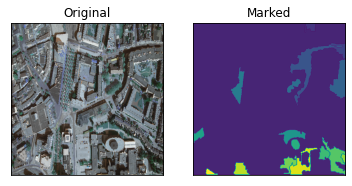

In [45]:
def main():
    # calling global variable
    global image_path
    '''The var Dataset is a list with all images in the folder '''
    dataset = loadImages(image_path)
    print('number of FILES in dir', len(dataset))
    print("--------------------------------")
    #print(cv2.imread(dataset[0]).shape)
    print("List of files the first 3 in the folder:\n",dataset[:3])
    print("--------------------------------")
    
    # sending all the images to pre-processing
    processing(dataset)
   
    #list files in directory
    #a = tf.gfile.ListDirectory('drive/My Drive/BiSeNet/dataset/train')
    #print(a)
  
main()